# Purpose


### 2021-12-23
One job that tried to do aggregate embeddings + distances completed the aggregation stage, but stalled/failed in the distance stage. We need to test whether the aggregated embeddings are in good enough shape to:
- run clustering models
    - clustering only needs the embeddings, not the distance matrices
- run distance job as a separate job
    - Maybe it's better to split the two jobs to free up some RAM and make retry logic easier.

---
### 2021-08-02: 
Now that I'm processing millions of comments and posts, I need to re-write the functions to try to do some work in parallel and reduce the amount of data loaded in RAM.

- `Dask` seems like a great option to load data and only compute some of it as needed.
    - update: `dask` failed silently on a 3TB RAM machine - job would run for like 6 hours but it would only save 1 or 2 parquet files out of an expected 100 files.
- `cuDF` could be a way to speed up some computation using GPUs
- `Dask-delayed` could be a way to create a task DAG lazily before computing all the aggregates.


# Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import os
import logging
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import dask
from dask import dataframe as dd
from tqdm import tqdm

import mlflow
import hydra

import subclu
from subclu.models.aggregate_embeddings import (
    AggregateEmbeddings, AggregateEmbeddingsConfig,
    load_config_agg_jupyter, get_dask_df_shape,
)
from subclu.models import aggregate_embeddings_pd

from subclu.utils import set_working_directory
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric
)
from subclu.utils.mlflow_logger import MlflowLogger, save_pd_df_to_parquet_in_chunks
from subclu.eda.aggregates import (
    compare_raw_v_weighted_language
)
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl
)


print_lib_versions([dask, hydra, mlflow, np, pd, plotly, sns, subclu])

python		v 3.7.10
===
dask		v: 2021.06.0
hydra		v: 1.1.0
mlflow		v: 1.16.0
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.4.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas').tail(8)

,experiment_id,name,artifact_location,lifecycle_stage
17,17,v0.4.0_use_multi_clustering_test,gs://i18n-subreddit-clustering/mlflow/mlruns/17,active
18,18,v0.4.0_use_multi_clustering,gs://i18n-subreddit-clustering/mlflow/mlruns/18,active
19,19,v0.4.1_mUSE_inference_test,gs://i18n-subreddit-clustering/mlflow/mlruns/19,active
20,20,v0.4.1_mUSE_inference,gs://i18n-subreddit-clustering/mlflow/mlruns/20,active
21,21,v0.4.1_mUSE_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/21,active
22,22,v0.4.1_mUSE_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/22,active
23,23,v0.4.1_mUSE_clustering_test,gs://i18n-subreddit-clustering/mlflow/mlruns/23,active
24,24,v0.4.1_mUSE_clustering,gs://i18n-subreddit-clustering/mlflow/mlruns/24,active


## Get runs from embeddings aggregation jobs

Want to make sure we can load these artifacts for other jobs

In [6]:
%%time

df_mlf_runs =  mlf.search_all_runs(experiment_ids=[ 22])
df_mlf_runs.shape

CPU times: user 58 ms, sys: 6.57 ms, total: 64.6 ms
Wall time: 63.5 ms


(1, 64)

In [7]:
df_mlf_runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.df_sub_level_agg_a_post_only-rows,metrics.comments_raw_rows,metrics.memory_total,metrics.df_post_level_agg_c_post_comments_sub_desc-cols,metrics.df_sub_level_agg_c_post_comments_and_sub_desc-cols,metrics.sub_description_raw_rows,metrics.memory_used,metrics.df_post_level_agg_c_post_comments_sub_desc-rows,metrics.cpu_count,metrics.df_sub_level_agg_a_post_only-cols,metrics.posts_raw_rows,metrics.memory_free,metrics.memory_used_percent,metrics.comments_raw_cols,metrics.df_sub_level_agg_c_post_comments_and_sub_desc-rows,metrics.posts_raw_cols,metrics.sub_description_raw_cols,params.col_subreddit_id,params.col_comment_text_len,params.agg_post_post_weight,params.run_name,params.memory_total,params.mlflow_experiment,params.col_text_comment_word_count,...,params.cpu_count,params.posts_folder,params.agg_comments_to_post_weight_col,params.agg_post_subreddit_desc_weight,params.f_log_file,params.n_sample_comments_files,params.agg_post_to_subreddit_weight_col,params.subreddit_desc_uuid,params.col_post_id,params.logs_path,params.mlflow_tracking_uri,params.host_name,params.col_comment_id,params.folder_subreddits_text_and_meta,params.comments_folder,params.folder_comments_text_and_meta,params.folder_posts_text_and_meta,params.unique_checks,params.col_text_post_word_count,params.calculate_b_agg_posts_and_comments,params.posts_uuid,params.agg_post_comment_weight,params.subreddit_desc_folder,params.comments_uuid,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.source.git.commit,tags.host_name,tags.mlflow.runName,tags.mlflow.user
0,4144c443722e47ef9cd2f42a5e813f3b,22,RUNNING,gs://i18n-subreddit-clustering/mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts,2021-12-23 11:20:55.413000+00:00,None,49625.0,54407324.0,1937274.0,515.0,514.0,49705.0,419733.0,15629958.0,80.0,514.0,15629958.0,1690826.0,0.216662,516.0,49625.0,515.0,514.0,subreddit_id,comment_text_len,70,agg_full_lc_false_pd-2021-12-23_112054,1937274,v0.4.1_mUSE_aggregates,comment_text_word_count,...,80,df_vect_posts,None,10,logs/AggregateEmbeddings/2021-12-23_11-20-55_agg_full_lc_false_pd-2021-12-23_112054.log,None,None,559a8f13264245b3923ab5699ef55bfe,post_id,logs/AggregateEmbeddings,sqlite,djb-100-2021-04-28-djb-eda-german-subs,comment_id,subreddits/top/2021-12-14,df_vect_comments,comments/top/2021-12-14,posts/top/2021-12-14_fix,False,text_word_count,False,559a8f13264245b3923ab5699ef55bfe,20,df_vect_subreddits_description,"['26c8fcf422a9403ba4a844c8e380bf7f', '54ba724869bf4ec9a2cad2a4f7eca048', 'e7ed11ccdc0b45abbdf3bf19605d4498', 'a69d1b259875458283124ffdaa6efbb6']",/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py,LOCAL,2e3ffe692433be950ce3fdfc0f164a9e3df6b0e4,djb-100-2021-04-28-djb-eda-german-subs,agg_full_lc_false_pd-2021-12-23_112054,jupyter


In [8]:
run_uuid = '4144c443722e47ef9cd2f42a5e813f3b'

In [9]:
# mask_finished = df_mlf_runs['status'] == 'FINISHED'
# mask_output_over_1M_rows = (
#     (df_mlf_runs['metrics.df_vect_posts_rows'] >= 1e5) |
#     (df_mlf_runs['metrics.df_vect_comments'] >= 1e5)
# )
# # df_mlf_runs[mask_finished].shape

# df_mlf_use_for_agg = df_mlf_runs[mask_output_over_1M_rows]
# df_mlf_use_for_agg.shape

In [10]:
# cols_with_multiple_vals = df_mlf_use_for_agg.columns[df_mlf_use_for_agg.nunique(dropna=False) > 1]
# # len(cols_with_multiple_vals)

# style_df_numeric(
#     df_mlf_use_for_agg
#     [cols_with_multiple_vals]
#     .drop(['artifact_uri', 'end_time',
#            # 'start_time',
#            ], 
#           axis=1)
#     .dropna(axis='columns', how='all')
#     .iloc[:, :30]
#     ,
#     rename_cols_for_display=True,
# )

# Check run artifacts

In [11]:
l_artifacts_top_level = mlf.list_run_artifacts(
    run_id=run_uuid,
    only_top_level=True,
    verbose=True,
)
len(l_artifacts_top_level)

00:33:06 | INFO | "   212 <- Artifacts to check count"
00:33:06 | INFO | "   212 <- Artifacts clean count"
00:33:06 | INFO | "     5 <- Artifacts & folders at TOP LEVEL clean count"


5

In [12]:
l_artifacts_all = mlf.list_run_artifacts(
    run_id=run_uuid,
    only_top_level=False,
    verbose=False,
)
len(l_artifacts_all)

00:33:08 | INFO | "   212 <- Artifacts clean count"
00:33:08 | INFO | "     5 <- Artifacts & folders at TOP LEVEL clean count"


212

In [13]:
l_artifacts_top_level

['config',
 'd_logged_dfs_subfolders',
 'df_post_level_agg_c_post_comments_sub_desc',
 'df_sub_level_agg_a_post_only',
 'df_sub_level_agg_c_post_comments_and_sub_desc']

In [14]:
l_sub_c = [i for i in l_artifacts_all if 'df_sub_level_agg_c_post_comments_and_sub_desc' in i]
print(len(l_sub_c))
l_sub_c[:6]

5


['mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc/_common_metadata',
 'mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc/_metadata',
 'mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc/part.0.parquet',
 'mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc/part.1.parquet',
 'mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc/part.2.parquet']

In [24]:
l_post_c = [i for i in l_artifacts_all if 'df_post_level_agg_c_post_comments_sub_desc' in i]
print(len(l_post_c))
l_post_c[:6]

197


['mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_post_level_agg_c_post_comments_sub_desc/_common_metadata',
 'mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_post_level_agg_c_post_comments_sub_desc/_metadata',
 'mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_post_level_agg_c_post_comments_sub_desc/part.0.parquet',
 'mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_post_level_agg_c_post_comments_sub_desc/part.1.parquet',
 'mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_post_level_agg_c_post_comments_sub_desc/part.10.parquet',
 'mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_post_level_agg_c_post_comments_sub_desc/part.100.parquet']

# Load aggregated embeddings

use `gsutil` to download embeddings for posts b/c that can take a LONG time to download sequentially. `gsutil` makes parallel downloaidng much faster and reports download speeds above 500MB / s:
```bash
ents_sub_desc/part.67.parquet...
/ [2/197 files][ 61.7 GiB/ 75.4 GiB]  81% Done 632.0 MiB/s ETA 00:00:22
```

In [25]:
%%time
# use gsutil to download post-level embeddings b/c it'll be much faster to run it in parallel

remote_key =  'mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_post_level_agg_c_post_comments_sub_desc'
print(remote_key)
# Need to remove the last part of the local path otherwise we'll get duplicate subfolders:
#. top/2021-12-14/2021-12-14 instead of top/2021-12-14
local_f = f"/home/jupyter/subreddit_clustering_i18n/data/local_cache/{'/'.join(remote_key.split('/')[:-1])}"
Path(local_f).mkdir(parents=True, exist_ok=True)
remote_gs_path = f"gs://i18n-subreddit-clustering/{remote_key}"

# !gsutil -m cp -r -n $remote_gs_path $local_f

mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_post_level_agg_c_post_comments_sub_desc
CPU times: user 773 µs, sys: 1.13 ms, total: 1.91 ms
Wall time: 1.17 ms


In [26]:
%%time

df_agg_posts_c = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder='df_post_level_agg_c_post_comments_sub_desc',
    read_function='pd_parquet',
    verbose=False,
)

00:53:17 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_post_level_agg_c_post_comments_sub_desc"
100%|######################################| 197/197 [00:00<00:00, 20147.71it/s]
00:53:17 | INFO | "  Parquet files found:   195"
00:53:17 | INFO | "  Parquet files to use:   195"


CPU times: user 5min 15s, sys: 10min 13s, total: 15min 29s
Wall time: 29.7 s


In [32]:
%%time

df_agg_sub_c = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder='df_sub_level_agg_c_post_comments_and_sub_desc',
    read_function='pd_parquet',
    verbose=False,
)

00:54:16 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc"
100%|###########################################| 5/5 [00:00<00:00, 9532.51it/s]
00:54:16 | INFO | "  Parquet files found:     3"
00:54:16 | INFO | "  Parquet files to use:     3"


CPU times: user 2.38 s, sys: 1.28 s, total: 3.66 s
Wall time: 2.23 s


In [27]:
%%time

df_agg_sub_a = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder='df_sub_level_agg_a_post_only',
    read_function='pd_parquet',
    verbose=False,
)

00:54:05 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_sub_level_agg_a_post_only"
100%|###########################################| 4/4 [00:00<00:00, 6041.49it/s]
00:54:05 | INFO | "  Parquet files found:     2"
00:54:05 | INFO | "  Parquet files to use:     2"


CPU times: user 2.3 s, sys: 734 ms, total: 3.03 s
Wall time: 2.38 s


In [28]:
df_agg_posts_c.shape

(15629958, 516)

In [33]:
df_agg_sub_c.shape

(49625, 515)

In [34]:
df_agg_sub_a.shape

(49625, 515)

In [35]:
df_agg_sub_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49625 entries, 0 to 49624
Columns: 515 entries, index to embeddings_511
dtypes: float64(512), int64(1), object(2)
memory usage: 195.0+ MB


In [36]:
df_agg_posts_c.iloc[:5, :25]

,index,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20
0,2791295,0hthaatsjaay,t5_46wt4h,t3_qfq0fq,0.087201,-0.066505,0.029690,0.012298,-0.034952,0.053689,0.044414,0.017155,-0.046440,0.015383,0.012840,-0.043312,-0.090698,-0.024975,-0.033056,0.038098,-0.037081,-0.008864,0.067694,0.010342,0.002464
1,2791489,0hthaatsjaay,t5_46wt4h,t3_qfq163,-0.014893,-0.005761,0.037109,0.053042,0.061703,0.052544,0.020536,0.022204,-0.054771,-0.002391,0.000019,0.001501,0.043294,0.017671,0.032296,0.048372,-0.017067,-0.054860,0.051034,0.061256,0.003112
2,2791607,0hthaatsjaay,t5_46wt4h,t3_qfq1k4,0.135044,-0.037835,0.057955,-0.005002,-0.056381,0.031939,0.032611,0.035669,-0.126514,0.005509,0.042626,0.023241,0.023097,-0.074260,-0.049510,-0.020191,-0.039475,0.018881,-0.000867,0.098055,-0.010566
3,3797160,0hthaatsjaay,t5_46wt4h,t3_qinw6s,-0.010032,-0.007126,-0.048523,0.054912,0.027322,0.033056,0.072791,-0.071261,-0.052551,0.031176,0.037562,-0.029470,0.045328,-0.014092,0.054866,-0.015727,-0.016684,0.006172,0.032382,-0.062652,0.031533
4,3972674,0hthaatsjaay,t5_46wt4h,t3_qj6ikh,0.008103,-0.040166,-0.017824,0.010111,-0.074436,0.020248,0.049757,-0.036444,-0.073499,0.021333,-0.009652,-0.003759,0.020886,-0.023865,-0.004722,0.015783,0.034461,0.030138,0.004584,0.013077,-0.037465


In [37]:
df_agg_sub_c.iloc[:5, :25]

,index,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21
0,0,0hthaatsjaay,t5_46wt4h,-0.012697,0.002315,0.011109,-0.005984,-0.036264,0.008153,-0.001582,-0.017434,-0.034032,0.018810,0.021127,-0.022091,-0.011960,0.016237,0.010066,0.030702,0.011328,0.027796,0.011354,0.006510,-0.018133,-0.030889
1,1,0nlyfantastic0,t5_4byrct,-0.018998,-0.017210,0.007470,-0.003859,0.011523,0.042205,-0.018871,0.036121,-0.034871,0.012692,-0.005710,0.012133,-0.031327,0.025415,0.019227,0.007873,0.002596,-0.028780,0.054517,-0.012182,-0.013013,-0.045152
2,2,0nlyleaks,t5_36f9u6,-0.014206,-0.064709,-0.000853,-0.018357,0.039892,0.046341,0.024391,0.004530,-0.079281,0.013930,0.033977,-0.031651,-0.010252,-0.072903,0.031626,0.011762,0.027802,0.021372,0.022010,-0.066856,0.036344,-0.007425
3,3,0sanitymemes,t5_2qlzfy,-0.016652,-0.002637,0.002151,-0.000380,-0.004485,0.038169,-0.007977,-0.005778,-0.039986,0.004282,0.018017,0.006978,0.010490,-0.003704,0.001710,0.003726,0.022393,0.006149,0.002622,0.007001,-0.005759,-0.018756
4,4,0xpolygon,t5_2qgijx,-0.033193,0.038902,-0.033466,-0.051036,-0.000341,0.012167,0.009529,0.008731,-0.007742,0.013853,0.015495,0.009962,0.027135,0.006659,-0.013294,0.023316,0.021664,0.001649,0.001098,-0.002340,0.003297,-0.016152


In [38]:
df_agg_sub_a.iloc[:5, :25]

,index,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21
0,0,0hthaatsjaay,t5_46wt4h,-0.008737,-0.003735,0.012025,0.000209,-0.048428,0.001540,-0.004872,-0.019982,-0.031873,0.029286,0.011650,-0.021429,-0.012683,0.027084,0.007254,0.034424,0.022789,0.027058,0.009333,0.013284,-0.027427,-0.029811
1,1,0nlyfantastic0,t5_4byrct,-0.017429,-0.012775,0.006979,-0.006912,0.012196,0.045432,-0.013871,0.046064,-0.025477,0.007838,-0.009830,0.013930,-0.040543,0.024911,0.031853,0.014628,0.010967,-0.036002,0.053363,0.006203,-0.014488,-0.046072
2,2,0nlyleaks,t5_36f9u6,-0.021766,-0.067258,-0.001936,-0.018856,0.052094,0.053189,0.022196,0.007721,-0.083458,0.017441,0.030904,-0.029253,-0.010002,-0.080291,0.033500,0.017934,0.026705,0.025012,0.018864,-0.071757,0.053012,-0.011498
3,3,0sanitymemes,t5_2qlzfy,-0.016551,-0.002135,0.007749,0.001272,-0.013962,0.035703,-0.009103,-0.006231,-0.044954,-0.000888,0.023133,0.002766,-0.004338,0.005792,0.002800,0.008235,0.027866,0.015647,0.000907,0.007563,-0.009714,-0.023784
4,4,0xpolygon,t5_2qgijx,-0.032932,0.044802,-0.032849,-0.052426,-0.005188,0.021019,0.003894,0.003638,-0.010742,0.022078,0.022186,0.006908,0.025017,0.010448,-0.014299,0.032794,0.020419,0.001374,0.001823,-0.000526,0.004756,-0.013867


In [39]:
df_agg_sub_c.iloc[-10:, :25]

,index,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21
49615,49615,zweitmeinung,t5_4kv9wc,-0.040518,-0.011396,0.016183,-0.028422,-0.066712,0.028768,0.004953,0.008945,-0.053609,-0.000032,0.001619,-0.012450,0.040547,0.004345,-0.002199,-0.034676,-0.012779,0.004648,0.000397,0.036897,-0.015819,-0.017496
49616,49616,zwift,t5_33t8j,-0.027395,-0.015270,-0.006319,0.015369,-0.038437,0.020171,0.009737,-0.007263,-0.038737,-0.005224,-0.004557,-0.015082,0.044456,-0.020974,0.019693,0.022184,0.010257,-0.010002,0.008148,-0.007386,0.002608,-0.006747
49617,49617,zwiftracing,t5_3y6zfn,0.042906,-0.018738,-0.014533,0.003808,-0.000362,0.047995,0.014497,0.017367,-0.034752,0.044055,-0.006360,-0.023630,-0.053470,-0.005947,0.043232,-0.004975,-0.013311,0.028611,0.027053,-0.042135,0.020192,-0.035474
49618,49618,zwormz,t5_558h6l,0.001943,0.000050,-0.008841,0.013108,0.009782,0.013488,-0.004737,0.001171,-0.028631,0.011872,0.006817,0.001142,-0.025191,-0.030035,0.003945,0.012210,-0.002794,-0.027809,0.004584,0.033497,-0.011790,0.002807
49619,49619,zxspectrum,t5_2ttxf,-0.012092,-0.025742,-0.008750,-0.024969,-0.018628,-0.006174,0.004686,0.000021,-0.027414,0.008352,0.017394,-0.017908,0.014743,0.003561,-0.000998,-0.010820,0.023164,-0.011636,0.012579,0.005268,-0.001191,-0.020699
49620,49620,zyn,t5_38nx2,-0.022060,0.010046,-0.034310,-0.022542,-0.017596,0.041781,0.011894,-0.038841,-0.051343,0.007992,0.021627,0.003101,0.044853,0.018825,0.002892,0.011217,0.001206,-0.023233,0.013473,0.018096,0.010907,-0.000968
49621,49621,zyramains,t5_35la7,-0.002744,-0.016453,0.005965,-0.016609,-0.007815,0.065392,0.024101,-0.003512,-0.027948,0.010691,0.016709,-0.004660,0.029199,-0.004788,0.012306,0.001346,-0.011995,-0.020919,-0.000191,-0.002442,-0.018061,-0.014261
49622,49622,zyzz,t5_2sosg,-0.011185,0.014175,0.004697,-0.001609,-0.025836,0.031206,0.017154,-0.009301,-0.047893,0.001483,0.010634,0.014197,0.024161,-0.011832,0.016491,-0.001671,0.006479,-0.015113,0.019097,0.009557,-0.008552,-0.011907
49623,49623,zzzzz,t5_2wxmu,0.109239,0.028351,-0.039005,-0.012098,-0.044105,-0.030205,-0.000990,-0.029610,-0.040511,0.022615,-0.070672,-0.024646,-0.010884,0.013012,0.025176,-0.066089,-0.014818,0.033189,0.015380,0.000433,0.007034,0.098833
49624,49624,zzzzzzzzzzzzzzzzzzzz,t5_3an04,0.098792,0.029517,-0.038618,-0.002381,-0.054415,-0.021700,0.005971,-0.014944,-0.045893,0.020496,-0.060823,-0.017631,-0.010200,0.002900,0.024926,-0.050978,-0.009353,0.038723,0.017978,-0.000070,0.005893,0.103079


In [40]:
df_agg_sub_c.set_index(['subreddit_name', 'subreddit_id']).iloc[-10:, -25:]

,,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
subreddit_name,subreddit_id,,,,,,,,,,,,,,,,,,,,,,,,,
zweitmeinung,t5_4kv9wc,-0.049606,-0.003723,0.018062,-0.000828,0.003319,-0.002216,0.009453,0.034053,0.013795,0.016754,0.007996,-0.008880,-0.011670,0.046431,0.037674,-0.004488,-0.016103,0.009057,-0.048078,-0.030425,-0.000588,0.002215,-0.041592,0.005740,0.021093
zwift,t5_33t8j,-0.031398,-0.002078,0.002957,-0.012808,-0.021162,0.020466,0.015393,0.003180,-0.003386,0.004100,-0.002877,-0.000595,0.029560,-0.011612,0.008400,-0.025238,-0.031418,-0.003407,-0.019989,0.010214,-0.011306,0.018334,-0.046527,0.005429,0.041444
zwiftracing,t5_3y6zfn,-0.039847,0.022836,0.012352,0.008810,-0.037861,0.013858,0.011247,-0.029368,-0.001654,0.015738,0.014011,-0.016880,0.024602,-0.051032,-0.003447,-0.034110,-0.016581,0.033948,0.022694,0.024870,0.023376,-0.007125,-0.029760,-0.007066,0.005877
zwormz,t5_558h6l,-0.058537,-0.022394,-0.002704,-0.007873,-0.025101,0.029416,0.016471,-0.023368,-0.012384,-0.010386,0.012507,-0.015875,-0.021494,-0.041120,-0.025987,-0.021569,0.038278,0.022909,0.017683,0.025090,0.033941,0.015015,-0.013898,0.023680,0.039078
zxspectrum,t5_2ttxf,-0.033087,-0.000902,-0.003455,-0.007307,-0.041451,0.031294,0.014128,-0.005483,-0.007695,-0.020362,0.001855,0.007620,0.004192,-0.003788,-0.008233,-0.025084,0.009034,-0.003493,0.010381,-0.011461,-0.010940,0.005359,-0.001222,0.004957,0.029547
zyn,t5_38nx2,-0.023036,-0.016240,0.018125,-0.017074,-0.001700,0.033527,-0.003683,-0.016554,-0.015492,-0.015686,0.003956,0.022945,0.004399,-0.001594,0.000796,-0.033126,-0.004979,-0.009137,0.004460,-0.006980,-0.018232,0.005824,-0.032289,0.001285,0.034555
zyramains,t5_35la7,-0.025017,-0.011858,0.004925,0.006041,-0.041484,-0.006132,0.015479,0.023632,-0.009972,-0.010468,0.055831,-0.005089,0.020469,0.002624,0.015801,-0.022638,-0.039330,0.004063,0.031444,0.000213,-0.011705,-0.005687,-0.024724,0.005295,0.037316
zyzz,t5_2sosg,-0.022881,-0.013618,-0.000902,0.006354,-0.007748,0.029342,-0.005068,-0.002280,-0.004818,-0.017936,0.011011,-0.002341,-0.007580,-0.016175,-0.014943,-0.034036,0.008110,0.010289,0.015803,0.015288,-0.000576,0.019584,-0.016047,0.019339,0.038396
zzzzz,t5_2wxmu,-0.076955,-0.008399,-0.001095,-0.030460,-0.009503,-0.001509,0.038487,-0.033308,-0.054085,-0.046889,0.042259,-0.008645,0.008501,-0.034762,0.002975,-0.094829,0.007812,0.033262,0.053066,-0.036873,-0.033677,0.026849,0.041165,0.058032,-0.013433


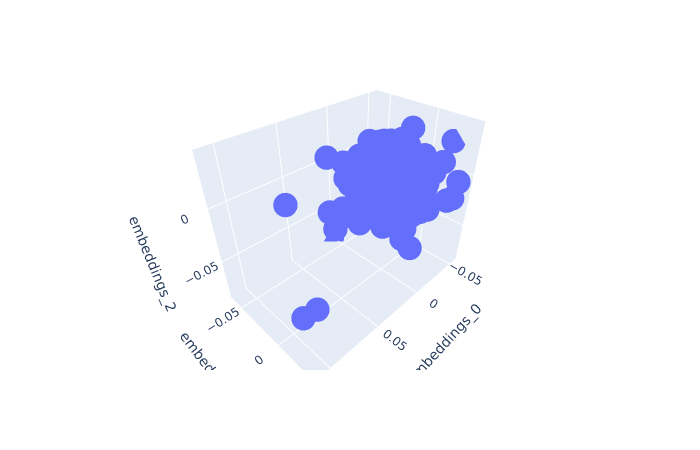

In [42]:
fig = px.scatter_3d(
    df_agg_sub_c.tail(200),
    x='embeddings_0',
    y='embeddings_1',
    z='embeddings_2',
    # text='subreddit_name',
    hover_data=['subreddit_name'],
)
fig.show(renderer='png')